### Grouping information sources into categories

Question 129 listed 17 information sources, and correspondents could check however many they used.

We decided to group the 17 information sources into 6 categories, to reduce the number of dimensions of the answer and make the data easier to analyse and present. This notebook processes the data from Question 129, makes a plot of results, and outputs a spreadsheet with the categorised responses for each subject.

In [1]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import collections
import numpy as np
%matplotlib inline

# Load data from files
dfU = pd.read_csv('source-data-aka-usb-stick/UgandaClean.mapped.csv')
dfK = pd.read_csv('source-data-aka-usb-stick/KenyaClean.mapped.csv')
countryData = {
    "Kenya": dfK,
    "Uganda": dfU
}

# Column name containing respondent IDs
SUBJECT_COLUMN = "SbjNum"
RESPONSE_COLUMN_PREFIX = "Q129.InformationFromWhere.O"

In [2]:
# This section defines the 6 categories
# Each category has a name
categoryNames = collections.OrderedDict([
    ("experiments", "Own experimentation"),
    ("sharing", "Informal sharing"),
    ("training", "Face-to-face training"),
    ("print", "Print media"),
    ("broadcast", "Broadcast media"),
    ("digital", "Digital media")
])

# Each answer code maps to one category
codeMapping = {
    1: "experiments",
    2: "sharing",
    3: "training",
    4: "training",
    5: "training",
    6: "broadcast",
    7: "digital",
    8: "digital",
    9: "print",
    10: "broadcast",
    11: "digital",
    12: "training",
    13: "sharing",
    14: "sharing",
    15: "sharing",
    16: "training",
    17: "print"
}

# Each category maps to a list of one or more answer codes
categoryCodes = collections.defaultdict(list)
for code,category in codeMapping.items():
    categoryCodes[category] += [code]

### Which categories of information did respondents use, across the two countries?

The following code finds the proportion of respondents in each country who got information from each category. Each respondent can get information from more than one categories, so the proportions add up to more than 1.

In [3]:
def getColumn(df, code, prefix = RESPONSE_COLUMN_PREFIX):
    return df[prefix + str(code)].values

def categoryColumn(category, country):
    df = countryData[country]
    codes = categoryCodes[category]
    matched_any = np.zeros_like(getColumn(df,1))
    for code in codes:
        matched_any = np.logical_or(matched_any, getColumn(df,code)==1)
    return map(int, matched_any)

def proportionHavingCategory(category, country):
    return np.mean(categoryColumn(category, country))

results = []
for category in categoryNames:
    results.append(dict(
        category = categoryNames[category],
        Kenya = proportionHavingCategory(category,"Kenya"),
        Uganda = proportionHavingCategory(category,"Uganda")
    ))
    
res_df = pd.DataFrame(results)
res_df = res_df.set_index("category")
res_df

,Kenya,Uganda
category,,
Own experimentation,0.643902,0.527869
Informal sharing,0.624390,0.619672
Face-to-face training,0.668293,0.675410
Print media,0.209756,0.144262
Broadcast media,0.736585,0.442623
Digital media,0.165854,0.059016


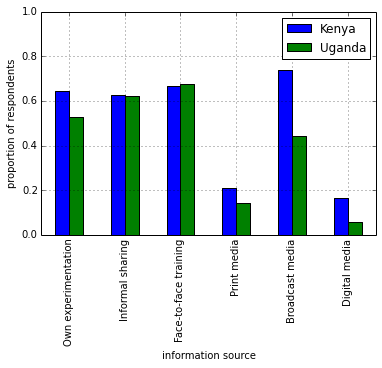

In [4]:
res_df.plot(kind="bar", grid="on")
plt.ylim(0,1)
plt.ylabel("proportion of respondents")
plt.xlabel("information source");

### Output the categorized responses for further analysis

The following code produces a new spreadsheet with a row for each subject, whith data from both countries combined. There is one column for each category, with a 1 if the subject used that category of information source, or a 0 otherwise.

Because CDPF are particularly interested in the effects of in-person training vs digital support, there is a "summary" column with four possible values, indicating whether the respondent used digital support, in-person training, both, or neither.

In [5]:
def summarizeInfoSource(digital, inPerson):
    summary = []
    for d,p in zip(digital, inPerson):
        if d and p:
            summary.append("both")
        elif d:
            summary.append("digital")
        elif p:
            summary.append("in-person")
        else:
            summary.append("neither")
    return summary
    
outData = []
for country,df in countryData.items():
    countryOutData = {
        SUBJECT_COLUMN: df[SUBJECT_COLUMN].values,
    }
    for category in categoryNames:
        countryOutData[category] = categoryColumn(category, country)
    countryOutData["country"] = country
    countryOutData["summary"] = summarizeInfoSource(
        countryOutData["digital"],
        countryOutData["training"])
    countryOutData["satisfaction"] = df["Q128.SatisfactionSupportInformation"].values
    outData.append(pd.DataFrame(
            countryOutData,
            index=df[SUBJECT_COLUMN].values,
            columns=["SbjNum","country"] + list(categoryNames.keys()) + ["summary","satisfaction"]))
outData = pd.concat(outData)
outData.to_csv("processed_data/Q129InformationSources.csv", index=False)

# Print counts of how many subjects fell into each category of the "summary" column
print(outData.groupby("summary").count().country)

summary
both          29
digital       23
in-person    314
neither      144
Name: country, dtype: int64
